## MTCNN & CNN & colab video

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install MTCNN

In [3]:
import cv2
import requests
from io import BytesIO
# extract and plot each detected face in a photograph
from matplotlib import pyplot
from matplotlib.patches import Rectangle,Circle
from mtcnn import MTCNN
# from mtcnn.mtcnn import MTCNN
# from google.colab.patches import cv2_imshow
import zipfile
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder,Normalizer
from sklearn.svm import SVC
from random import choice
from PIL import Image as Img
from numpy import savez_compressed,asarray,load,expand_dims
from keras.models import load_model
# from keras_facenet import FaceNet
import tensorflow as tf
from tensorflow.keras import layers, models
import time

In [4]:
# class Data_Using:

def unzip(zip_dir,out_dir):
    path_folder = out_dir

    zip_file_path = f'{zip_dir}'
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(path_folder)


def load_dataset(directory):
  	# enumerate folders, on per class
  images = []
  path_d = []
  allpath = []
  y = []
  for subdir in os.listdir(directory):

    # print(y)
       	# enumerate files
    for filename in os.listdir(directory+subdir+'/'):
      path = directory + subdir + '/' + filename
          #labels
      y.append(subdir)
      path_d.append(path)
      # print(path_d)
  # allpath.extend(path_d)

  print(path_d)
	  	# store
    # images.append(path_d)
  return path_d , y


def load_data_image(path_image):
    img = cv2.imread(path_image)
    # img = cv2.cvtColor(img,cv2.COLOR)
    return img


def load_data_video(path_video):

    frame_list = []
    # Load the video content using OpenCV
    cap = cv2.VideoCapture(path_video)
    # Loop through the frames and display them
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        # Display the frame
        # cv2_imshow( frame)

        frame_list.append(frame)

        # Press 'q' to exit the loop
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    # Release the video capture object and close all windows
    cap.release()
    cv2.destroyAllWindows()
    frame_list = np.array(frame_list)
    return frame_list



def load_data_system_camera():
    # define a video capture object
    vid = cv2.VideoCapture(0)
    while(True):
        # Capture the video frame
        ret, frame = vid.read()
        # Display the resulting frame
        cv2.imshow('frame', frame)
        # cv2.imwrite('video.mp4',frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    # After the loop release the cap object
    vid.release()
    # Destroy all the windows
    cv2.destroyAllWindows()



In [5]:
from functools import wraps
import sys
import io
def capture_output(func):
    """Wrapper to capture print output."""

    @wraps(func)
    def wrapper(*args, **kwargs):
        old_stdout = sys.stdout
        new_stdout = io.StringIO()
        sys.stdout = new_stdout
        try:
            return func(*args, **kwargs)
        finally:
            sys.stdout = old_stdout

    return wrapper

In [6]:
class Face_Detection_Recognition_Video:

    def __init__(self):
      # super.__init__(self)
      self.face_number = 0
      self.folder_number = 0
      self.detector = MTCNN()
      self.w_detect = capture_output( self.detector.detect_faces)

    # def preprocess(self,image):
    #   #normalize
    #     pixels = image.astype('float32')
    #     pixels /= 255.0
    #     return pixels

      # draw each face separately
    def mtcnn_model(self,data, result_list):
        # get the context for drawing boxes
        # ax = pyplot.gca()
        # for result in result_list:
        #   # get coordinates
        #   x, y, width, height = result['box']
        #   # create the shape
        #   rect = Rectangle((x, y), width, height, fill=False, color='red')
        #   # draw the box
        #   ax.add_patch(rect)
        #   # draw the dots
        #   for key, value in result['keypoints'].items():
        #   # create and draw dot
        #     dot = Circle(value, radius=2, color='red')
        #     ax.add_patch(dot)
        # pyplot.show()
        crop_face = []
        for i in range(len(result_list)):
          # get coordinates
          x1, y1, width, height = result_list[i]['box']
          x2, y2 = x1 + width, y1 + height
          # define subplot
          # pyplot.subplot(1, len(result_list), i+1)
          # pyplot.axis('off')
          # plot face
          Face = data[y1:y2, x1:x2]
          # resize pixels to the model size
          Face = Img.fromarray(Face)
          Face = Face.convert('RGB')
          Face = Face.resize((160,160))
          Face = asarray(Face)#,dtype=np.float32)
          crop_face.append(Face)

        return crop_face


    def get_face(self,path):
        pixels = path
        pixels = asarray(pixels)
        # detector = MTCNN()
        # detect faces in the image
        # w_detect = capture_output( self.detector.detect_faces)
        start_1=time.time()
        faces_pos = self.w_detect(pixels)
        # stop=time.time()
        start=time.time()
        Faces = self.mtcnn_model(pixels, faces_pos)
        stop=time.time()
        print('detect_time:',start-start_1)
        print('all_time:',stop-start_1)
        # print(stop)

        return Faces , faces_pos


    def model_CNN(self):
      model_cnn = models.Sequential([
      layers.Conv2D(16, (3, 3), activation='relu', input_shape=(160, 160, 3)),
      layers.MaxPooling2D((2, 2)),
      layers.Conv2D(32, (3, 3), activation='relu'),# input_shape=(160, 160, 3)),
      layers.MaxPooling2D((2, 2)),
      # layers.Dropout(0.2),
      layers.Conv2D(64, (3, 3), activation='relu'),
      layers.MaxPooling2D((2, 2)),
      # layers.Dropout(0.2),
      layers.Conv2D(128, (3, 3), activation='relu'),
      layers.MaxPooling2D((2, 2)),
      layers.Flatten(),
      layers.Dense(512, activation='relu'),
      layers.Dropout(0.2),  # Dropout for regularization
      layers.Dense(128, activation='relu'),
      # layers.Dropout(0.2),
      # layers.Dense(64, activation='relu'),
      layers.Dense(9, activation='softmax')  # num_classes is the number of identities
      ])

      return model_cnn

    def train_cnn_model(self,trainx,trainy,testx, testy,E_number):
      self.model = self.model_CNN()
      self.model.summary()
      self.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
      self.model.fit(trainx, trainy, epochs= E_number)
      test_loss, test_acc = self.model.evaluate(testx, testy)
      return self.model , test_loss, test_acc


    def recognition_model(self,image,model):
      random_face = np.array(image)
      random_face = random_face.reshape(1,160,160,3)
      w_predict = capture_output(self.model.predict)
      pred = w_predict(random_face)
      # random_face_name = out_encoder.inverse_transform([random_face_class])
      out_encoder = LabelEncoder()
      out_encoder.fit(trainy)
      class_index = tf.argmax(pred, axis=1)
      # confidence = tf.reduce_max(pred[0][random_face_class])
      pred_name = out_encoder.inverse_transform(class_index)
      # print('Predicted: %s' % pred_name)
      # print('Expected: %s' % random_face_name[0])
      # print(f"Predicted class: {class_index}, Confidence: {confidence * 100:.2f}%")
      # pyplot.figure()
      # pyplot.imshow(random_face.reshape(160,160,3))
      # pyplot.show()
      return pred_name

    def save_faces(self,data_face):
      folder_name = 'Faces'+f'{self.folder_number}'
      if not os.path.isdir(folder_name):
        os.mkdir(folder_name)
      cv2.imwrite(folder_name + '/' + f'{self.face_number}.jpg',data_face)
      self.face_number += 1

    def face_counting(self,):
      pass

In [7]:
path = '/content/drive/MyDrive/Facenet/Facedata.zip'
output = '/content/photos'
data = unzip(path,output)

In [8]:
!rm -R /content/photos/__MACOSX

In [9]:
!find . -name "*.DS_Store" -type f -delete

In [ ]:
# Load dataset

def faces_dataset(directory):
  X = list()
  newlabels = list()
  files , labels = load_dataset(directory)
  print(len(files),len(labels))
  for fil,label in zip(files,labels):
    facedetect = Face_Detection_Recognition_Video()
    img = load_data_image(fil)
    if not type(img) == type(None):
     faces , pos = facedetect.get_face(img)
    if not len(faces)== 0:
      X.append(faces)
      newlabels.append(label)

  return asarray(X), asarray(newlabels)



# paths train and validation
train_path = '/content/photos/train/'
val_path = '/content/photos/val/'
# load train dataset
trainX, trainy = faces_dataset(train_path)
# load test dataset
testX, testy = faces_dataset(val_path)
# save arrays to one file in compressed format
# savez_compressed('5-celebrity-faces-dataset.npz', trainX, trainy, testX, testy)

In [11]:
# Prepare data for Cnn

Cnn_trainx = []
for p in trainX:
  Cnn_trainx.append(p[0])
Cnn_trainx = np.array(Cnn_trainx)
print(Cnn_trainx.shape)

Cnn_testx = []
for p in testX:
  Cnn_testx.append(p[0])
Cnn_testx = np.array(Cnn_testx)
print(Cnn_testx.shape)

# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
train_y = out_encoder.transform(trainy)
print(train_y.shape)
test_y = out_encoder.transform(testy)
print(test_y.shape)

(230, 160, 160, 3)
(44, 160, 160, 3)
(230,)
(44,)


In [12]:
# Train model
face_detect = Face_Detection_Recognition_Video()
train_model = face_detect.train_cnn_model(Cnn_trainx,train_y,Cnn_testx,test_y,100)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3468 (Conv2D)        (None, 158, 158, 16)      448       
                                                                 
 max_pooling2d_1734 (MaxPool  (None, 79, 79, 16)       0         
 ing2D)                                                          
                                                                 
 conv2d_3469 (Conv2D)        (None, 77, 77, 32)        4640      
                                                                 
 max_pooling2d_1735 (MaxPool  (None, 38, 38, 32)       0         
 ing2D)                                                          
                                                                 
 conv2d_3470 (Conv2D)        (None, 36, 36, 64)        18496     
                                                                 
 max_pooling2d_1736 (MaxPool  (None, 18, 18, 64)       0

In [ ]:
train_model[0].save_weights('/content/drive/MyDrive/Facenet/Model/weightmodel')
train_model[0].save('/content/drive/MyDrive/Facenet/Model/Mymodel.h5')

In [ ]:
# recognition face in photo
image = load_data_image('/content/photos/train/zahra_dabiri/20220609_210252.jpg')
face_detect = Face_Detection_Recognition_Video()
faces , pos = face_detect.get_face(image)
# print(image.shape)
for i in range(len(faces)):
  recog_model = face_detect.recognition_model(faces[i],train_model)
  pyplot.figure()
  pyplot.imshow(image)
  ax = pyplot.gca()
  # get coordinates
  x, y, width, height = pos[i]['box']
  # create the shape
  rect = Rectangle((x, y), width, height, fill=False, color='red')
  # draw the box
  ax.add_patch(rect)

In [13]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
from PIL import Image as Img
import io
import html
import time

In [14]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = Img.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [15]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [16]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0

while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # get face region coordinates
    faces , pos = face_detect.get_face(img)
    # get face bounding box for overlay
    # for (x,y,w,h)in pos:
    #   bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)
    for i in range(len(faces)):
      recog_model = face_detect.recognition_model(faces[i],train_model)
      txt = recog_model[0]
      # print(txt , type(txt))
      font = cv2.FONT_HERSHEY_SIMPLEX
      # fontScale
      fontScale = 1
      # Blue color in BGR
      color = (255, 0, 0)
      # Line thickness of 2 px
      thickness = 2

      x, y, w, h = pos[i]['box']
      # cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
      bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)
      bbox_array = cv2.putText(bbox_array,txt,(x,y-10),font,fontScale,color,thickness)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>

detect_time: 1.288156270980835
all_time: 1.2881629467010498
detect_time: 1.7811272144317627
all_time: 1.783987045288086
detect_time: 0.940363883972168
all_time: 0.9420263767242432
detect_time: 0.9572761058807373
all_time: 0.9590651988983154
detect_time: 0.9216337203979492
all_time: 0.9234073162078857
detect_time: 0.9193572998046875
all_time: 0.9209990501403809
detect_time: 1.4058005809783936
all_time: 1.4087865352630615
detect_time: 0.9195396900177002
all_time: 0.9210314750671387
detect_time: 0.9212265014648438
all_time: 0.9227612018585205
detect_time: 0.9142789840698242
all_time: 0.915369987487793
detect_time: 1.3764195442199707
all_time: 1.3782432079315186


In [ ]:
img = cv2.cvtColor(cv2.imread("/content/photos/train/zahra_dabiri/20220609_210252.jpg"), cv2.COLOR_BGR2RGB)
detector = MTCNN()
start=time.time()
detector.detect_faces(img)#[
#     {
#         'box': [277, 90, 48, 63],
#         'keypoints':
#         {
#             'nose': (303, 131),
#             'mouth_right': (313, 141),
#             'right_eye': (314, 114),
#             'left_eye': (291, 117),
#             'mouth_left': (296, 143)
#         },
#         'confidence': 0.99851983785629272
#     }
# ]
stop=time.time()
print(stop-start)

1/1 [==============================] - 0s 211ms/step
56.64801621437073


## Don't need these parts

In [ ]:
# Human face counting

# Load the pre-trained MTCNN model for face detection
detector = MTCNN()

# Initialize variables
person_counter = 0
person_detected = False

# Open the video capture
cap = cv2.VideoCapture(0)  # Change to the path of your video file if needed

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Detect faces using MTCNN
    faces = detector.detect_faces(frame)

    for face in faces:
        x, y, width, height = face['box']

        # Draw a rectangle around the detected face
        cv2.rectangle(frame, (x, y), (x + width, y + height), (255, 0, 0), 2)

        # Check if a person is detected
        if width > 100 and height > 100:  # Adjust the size threshold based on your scenario
            if not person_detected:
                person_counter += 1
                person_detected = True
        else:
            person_detected = False

    # Display the frame with the person count
    cv2.putText(frame, f'Person Count: {person_counter}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.imshow('Person Counting', frame)

    # Break the loop when 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture and close all windows
cap.release()
cv2.destroyAllWindows()


In [ ]:
!pip install keras-facenet

In [ ]:
# path_image = '/content/14605565-c91a-49b0-ba59-39c70413e734.jpeg'
# path_video = '/content/video1.mp4'
# output = 'C:/Users/Zahra.Dabiri/Downloads'
# face_result = Face_Detection_Recognition_Video()
# d = load_data_image(path_image)
# a , b=face_result.get_face(d)
# print(type(a))


# data = load_data_video(path_video)
# import json
# # cam = load_data_colab_camera()
# face_dataset = []
# for i in range(len(d)):
#   faces , pose = face_result.get_face(d[i])
#   face_dataset.append({'face':faces,'position':pose})
# # print(face_dataset)
#   for j in range(len(faces)):
#     face_result.save_faces(faces[j])



In [ ]:
# calculate a face embedding for each face in the dataset using facenet

def get_embedding(face_img):

    face_img = face_img.astype('float32') # 3D(160x160x3)
    face_img = asarray(face_img)
    face_img = np.expand_dims(face_img, axis=0)
    # 4D (Nonex160x160x3)
    yhat= embedder.embeddings(face_img)
    return yhat[0] # 512D image (1x1x512)

embedder = FaceNet()

# load the face dataset
# data = load('5-celebrity-faces-dataset.npz',allow_pickle=True)

# trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX[0][0].shape, testy.shape)

# convert each face in the train set to an embedding
newTrainX , newTrainy = list(),list()
for face_pixels,label in zip(trainX,trainy):
  try:
    embedding = get_embedding(face_pixels[0])
    newTrainX.append(embedding)
    newTrainy.append(label)
  except:
    print(label)
newTrainX = asarray(newTrainX)
print(newTrainX.shape)

# convert each face in the test set to an embedding
newTestX ,newTesty = list(),list()
for face_pixels,label in zip(testX,testy):
  try:
    embedding = get_embedding(face_pixels[0])
    newTestX.append(embedding)
    newTesty.append(label)
  except:
    print(label)
newTestX = asarray(newTestX)
print(newTestX.shape)
# save arrays to one file in compressed format
# savez_compressed('5-celebrity-faces-embeddings.npz', newTrainX, newTrainy, newTestX, newTesty)


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Create an ImageDataGenerator instance with desired augmentations
datagen = ImageDataGenerator(
    rescale=1./255,             # Normalize pixel values to [0,1]
    rotation_range=20,          # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,      # Randomly shift images horizontally by up to 20% of the width
    height_shift_range=0.2,     # Randomly shift images vertically by up to 20% of the height
    shear_range=0.2,            # Apply random shear transformations
    zoom_range=0.2,             # Apply random zoom transformations
    horizontal_flip=True,       # Randomly flip images horizontally
    fill_mode='nearest'         # Fill in newly created pixels after rotation or shifts
)

# Combine your images and labels into one generator
combined_data = list(zip(Cnn_trainx, train_y))

# Shuffle the combined data
# np.random.shuffle(combined_data)

# Split the combined data back into images and labels
shuffled_images, shuffled_labels = zip(*combined_data)

# Create a generator for the shuffled data
generator = datagen.flow(
    np.array(shuffled_images),
    np.array(shuffled_labels))
   # ,batch_size=32  # Number of images in each batch)

# # Example: Visualizing augmented images
# example_batch = generator.next()
# for i in range(0, 4):
#     plt.subplot(2, 2, i+1)
#     plt.imshow(example_batch[0][i])
# plt.show()

# Train the model using the generator
model_cnn.fit_generator(
    generator,
    epochs=80)
    #,steps_per_epoch=len(Cnn_trainx) // 32,  # Number of batches per epoch)

# After training, you can evaluate the model on a test set if available
# model.evaluate(test_generator, steps=len(test_images) // 32)


In [ ]:
# Classifier with CNN

model_cnn = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(160, 160, 3)),
    layers.MaxPooling2D((2, 2)),
    # layers.Dropout(0.2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    # layers.Dropout(0.2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),  # Dropout for regularization
    layers.Dense(256, activation='relu'),
    layers.Dense(5, activation='softmax')  # num_classes is the number of identities
])
model_cnn.summary()
# Compile the model
model_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model (assuming you have X_train and y_train as your training data)
model_cnn.fit(Cnn_trainx, train_y, epochs=40)# ,validation_data=(testX, test_y))


In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model_cnn.evaluate(Cnn_testx, test_y)
print(f'Test accuracy: {test_acc}')

1/1 [==============================] - 0s 246ms/step - loss: 4.9960 - accuracy: 0.5833
Test accuracy: 0.5833333134651184


1/1 [==============================] - 0s 88ms/step
[[1.3606957e-05 3.3928975e-06 9.9998283e-01 1.1566690e-07 8.0049006e-10]]
Predicted: ['jerry_seinfeld']
Expected: jerry_seinfeld
Predicted class: [2], Confidence: 100.00%


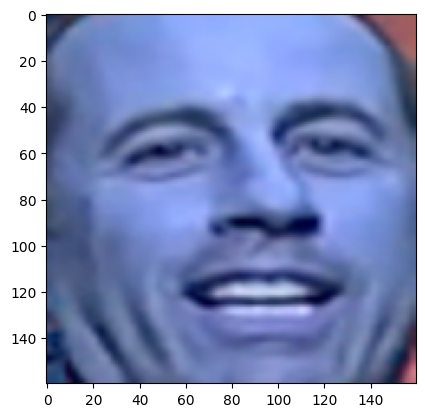

In [ ]:
# in_encoder = Normalizer(norm='l2')
# test_X = in_encoder.transform(test_X)
# print(train_X.shape)
# label encode targets


# print(random_face_pixels.shape)
random_face = np.array(random_face_pixels)
random_face = random_face.reshape(1,160,160,3)
# print(random_face.shape)
pred = model_cnn.predict(random_face)
print(pred)
random_face_name = out_encoder.inverse_transform([random_face_class])
# print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
# print('random_face_class',pred[0][random_face_class])

class_index = tf.argmax(pred, axis=1)
confidence = tf.reduce_max(pred[0][random_face_class])
pred_name = out_encoder.inverse_transform(class_index)
print('Predicted: %s' % pred_name)
print('Expected: %s' % random_face_name[0])
# Assuming you have a list of class labels
# class_label = test_y[class_index.numpy()[0]]

print(f"Predicted class: {class_index}, Confidence: {confidence * 100:.2f}%")

# plot for fun
# print(random_face_pixels.shape)
pyplot.imshow(random_face_pixels)
# title = '%s (%.3f)' % (random_face_name, pred_name)
# pyplot.title(title)
pyplot.show()

In [ ]:
# recognition face in video
from google.colab.patches import cv2_imshow
# video = load_data_video('/content/video_2.mp4')

# Load the pre-trained MTCNN model
# detector = MTCNN()

# Open a video capture object (0 corresponds to the default camera)
cap = cv2.VideoCapture('/content/video_2.mp4')

if not cap.isOpened():
    print("Error: Could not open video file.")
    exit()

while True:
    # Read a frame from the video capture
    ret, frame = cap.read()

    if not ret:
        break

    # Convert the frame to grayscale (MTCNN works on grayscale images)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces in the frame using MTCNN
    faces , pose = face_detect.get_face(frame)


    # Draw bounding boxes around the detected faces
    for face in  range(len(faces)):
        recog_model = face_detect.recognition_model(faces[face],train_model)
        pyplot.figure()
        # pyplot.imshow(image)
        ax = pyplot.gca()
        # get coordinates
        x, y, width, height = pose[face]['box']
        # create the shape
        rect = Rectangle((x, y), width, height, fill=False, color='red')
        # draw the box
        ax.add_patch(rect)
        # x, y, w, h = face['box']
        # cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)

    # Display the frame with bounding boxes

    # Display the frame
    _, img_encoded = cv2.imencode('.jpg', cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    display(Image(data=img_encoded.tobytes(), format='jpeg'))

    # cv2_imshow(frame)

    # Break the loop if 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture object
cap.release()

# Destroy all OpenCV windows
cv2.destroyAllWindows()


Error: Could not open video file.
